# Rupture Transition

In this notebook we explore the transition from a dimer state to a rupture state. The dimer state is created at low frequency because the interaction produced by the in-plane component of the dipole moments is strong enough to overcome the repulsive interactions caused by the out of plane moment. This dimer state is observed when the in-plane moment is static, and when the rotation is slow enough that the dimers rotate synchronous to the field. 

On the other hand, at large frequencies, the rotation of the dimer becomes asynchronous, and the in-plane interaction consists of an attractive part (when the moments are colinear), and a repulsive part (when the moments are parallel). The time average of this interaction is also attractive, but necessarily smaller than the purelly colinear interaction. This means that deppending on the field's cone angle, and on the confinement height, the total interaction can be either attractive or repulsive. If the interaction is attractive, the dimers will have an either asynchronous rotation (for low packing fractions) or an exchange (for high packing fraction). If the interaction is repulsive, the dimers will break; we call this the rupture state. 

In [1]:
import sys
import os
sys.path.insert(0, './confined-colloids')

import lammps2d as lmp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import matplotlib.collections as clt
import pandas as pd
import string as st
import scipy.spatial as spp
import scipy.optimize as spo
import sympy as smp
import copy as cp
import jsonpickle
import re

from IPython.display import HTML, clear_output

smp.init_printing()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

We first calculate an example of the equilibrium state. On a static out of plane field, for a low packing fraction the system falls into a repulsive state. The system keeps on relaxing, and it's therefore not completely solid, but it does appear to be mostly ordered, and it probably becomes solid given a little more time. 

In [2]:
angle = 0
radius = 1.4

region, initial_positions = lmp.initial_setup(n_of_particles = 150, packing=0.175, height = 4.0)

sim = lmp.sim(initial_positions,
          magnitude = 7.28*3,
          file_name = "equilibrium_angle0",
          dir_name = "C:/Users/aortiza/Desktop/RuptureTransition",
          radius = radius,
          diffusion = 0.073,
          frequency=0,
          susceptibility = 0.4,
          angle=angle,
          framerate=1e1,
          timestep=0.5e-4,
          total_time = 300,
          temperature = 300,
          stamp_time = False,
          space = {'region':region,'boundary':['p','p','f'],'walls':[False,False,True]})

sim.generate_scripts()
sim.run()

In [3]:
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "equilibrium_angle0"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

In [4]:
trj = sim.lazy_read[0::10]

In [5]:
HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=7,speedup=30))

Then we added a in plane component, albeit a static one. Again, the system then falls to a solid state, with some defects. It remains to be seen if how many of these defects relax over time.

In [6]:
sim.field_parameters.angle=15
sim.sim_parameters.file_name="equilibrium_angle15"

sim.generate_scripts()
sim.run()

In [7]:
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "equilibrium_angle15"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0::10]

HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=7,speedup=30))

We now include a field with a varying frequency. In this example, the frequency goes from $f=0$ at $t=0$ to $f=1$Hz at $t=30s$.

The resulting system is always in the asynchronous regime. The video however, contains a low sampling rate, and the stroboscopic effect makes particles appear to go backwards. Below we can check that the magnetic moments actually follow the field. 

In [8]:
sim.field_parameters.frequency="0.00333e-6*time"
sim.sim_parameters.file_name="dynamic_angle15"

sim.generate_scripts()
sim.run()

In [9]:
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "dynamic_angle15"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0::10]

HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=7,speedup=30))

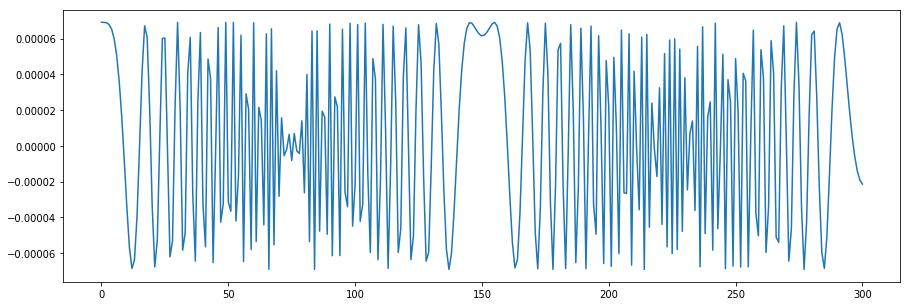

In [10]:
idx = pd.IndexSlice

trj['t']=trj.index.get_level_values('frame')*sim.run_parameters.timestep

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(trj.loc[idx[:,1],:].t,trj.loc[idx[:,1],:].muy)

Now we increase the rotation speed further. In this example, the frequency is given by $f=\frac{2\mathrm{Hz}}{3\mathrm{sec}}t$ $\forall t\in\left[0,30\mathrm{sec}\right]$

Here, the effect of the sampling is more notorious. It is even more notorious in the moment vs time plot, where it appears that the moment is not taking the expected values. 

In [11]:
sim.field_parameters.frequency="0.06666e-6*time"
sim.sim_parameters.file_name="dynamic_angle15_0_20Hz"

sim.generate_scripts()
sim.run()

In [12]:
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "dynamic_angle15_0_20Hz"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0::10]

HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=7,speedup=30))

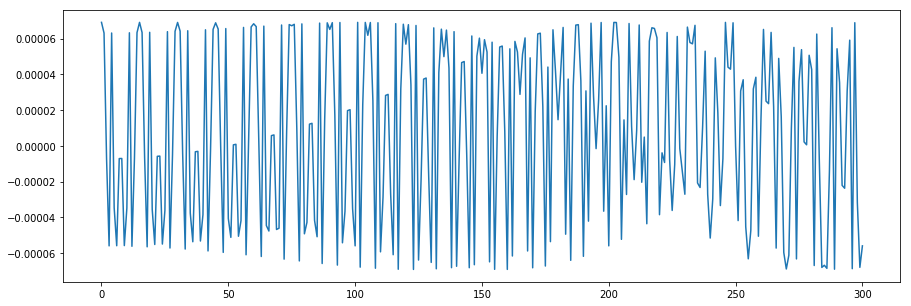

In [13]:
trj['t']=trj.index.get_level_values('frame')*sim.run_parameters.timestep

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(trj.loc[idx[:,1],:].t,trj.loc[idx[:,1],:].muy)

To check this, we increase the frame rate. In this case, even though the video still shows particles going back, at least the dipole moment appears to be spining faster every time.

In [14]:
sim.field_parameters.frequency="0.06666e-6*time"
sim.run_parameters.framerate = 1e2
sim.sim_parameters.file_name="dynamic_angle15_0_20Hz_100fps"

sim.generate_scripts()
sim.run()

In [15]:
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "dynamic_angle15_0_20Hz_100fps"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0:1000:1]

In [16]:
HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=7,speedup=3))

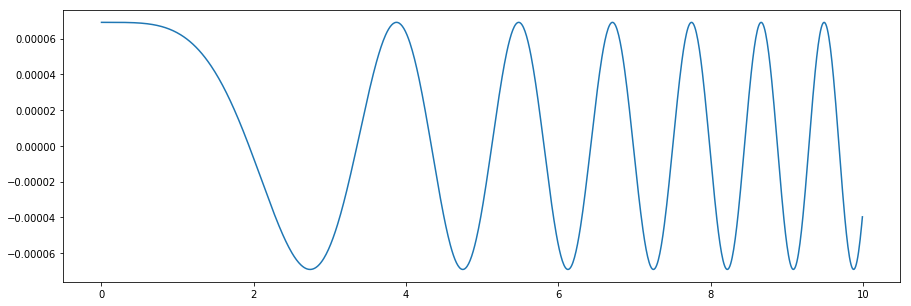

In [17]:
trj['t']=trj.index.get_level_values('frame')*sim.run_parameters.timestep

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(trj.loc[idx[:,1],:].t,trj.loc[idx[:,1],:].muy)

We now do a slower test with a lot more particles. This will give us more statistics, while also ensuring that the system remains at all times in an adiabatic regime. This run should take a few hours. 

In [48]:
angle = 15
radius = 1.4

region, initial_positions = lmp.initial_setup(n_of_particles = 2000, packing=0.175, height = 4.0)

sim = lmp.sim(initial_positions,
          magnitude = 7.28*3,
          file_name = "dynamic_angle15_0_20Hz_100fps_large",
          dir_name = "C:/Users/aortiza/Desktop/RuptureTransition",
          radius = radius,
          diffusion = 0.073,
          frequency="0.0666e-6*time",
          susceptibility = 0.4,
          angle=angle,
          framerate=1e2,
          timestep=0.5e-4,
          total_time = 300,
          temperature = 300,
          stamp_time = False,
          space = {'region':region,'boundary':['p','p','f'],'walls':[False,False,True]})

sim.generate_scripts()
sim.run()

This took about 6 hours, but the trajectory loading is super slow. We should take into account that the file is 6gb

In [49]:
%%time
sim.load(read_trj=False)

Wall time: 51.1 s


This is feasible. Now I can load the data I need. 

In [50]:
%%time
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "dynamic_angle15_0_20Hz_100fps_large"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0:1000:1]

Wall time: 4min 53s


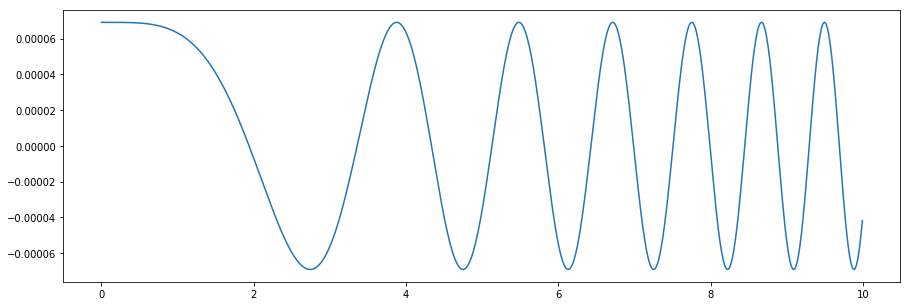

In [52]:
trj['t']=trj.index.get_level_values('frame')*sim.run_parameters.timestep

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(trj.loc[idx[:,1],:].t,trj.loc[idx[:,1],:].muy)

In [53]:
%%time
directory = "C:/Users/aortiza/Desktop/RuptureTransition"
file = "dynamic_angle15_0_20Hz_100fps_large"

f = open(os.path.join(directory,file)+'.jp')
json_str = f.read()
sim = jsonpickle.decode(json_str)

sim.load(read_trj=False)

trj = sim.lazy_read[0::30]

Wall time: 5min 7s


In [55]:
%%time 
HTML(lmp.display_animation_direct(sim,trj,start=0,end=300,step=10,speedup=30))

Wall time: 3min 28s


# Number of Dimers vs Frequency

In [85]:
%%time

from tqdm import tqdm_notebook

def count_in_frame(i):
    trj = sim.lazy_read[i]
    dim = lmp.dimers(trj, sim, distance=3)
    dim = lmp.dimers_findpositions(dim,trj,sim)
    dim = strict_dimers(dim)
    return sum(dim.strict.values)

N = [count_in_frame(i) for i in tqdm_notebook(range(0,len(sim.lazy_read.T),300))]

A Jupyter Widget

Wall time: 1h 4min 53s


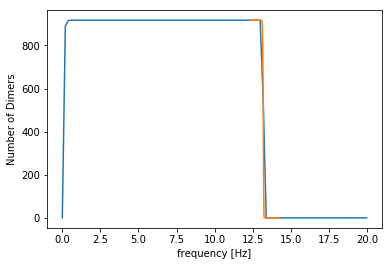

In [103]:
plt.plot(0.0666*np.linspace(0,300,101),N),
plt.plot(0.0666*np.arange(18500,21500,30)/100,Nhigh_res)
plt.xlabel('frequency [Hz]')
plt.ylabel('Number of Dimers')

In [72]:
def strict_dimers(dim):
    """ Marks those dimers that are not strict as non_strict. """
    idx = pd.IndexSlice

    frames = dim.index.get_level_values("frame").unique().values
    dim_ids = dim.loc[idx[frames[::]]].index.get_level_values("id").unique().values

    not_strict = np.array([],dtype=[("frame",'i'),("id",'f')])

    for i,d_id in enumerate(dim_ids):
        
        members = dim.loc[idx[:,d_id],"members"].iloc[0]
        
        """ timespan is the set of frames where the dimer d_id exists""" 
        timespan = dim.loc[idx[:,d_id],:].index.get_level_values("frame").unique().values
        """ coexisting is an array of all the dimers that exist in the same timespan"""
        coexisting = dim.loc[idx[tuple(timespan),np.delete(dim_ids,i)],"members"]
        
        third_neighbors = np.array([index for dimer,index in zip(coexisting,coexisting.index) 
                                    if bool(dimer.intersection(members))],dtype=[("frame",'i'),("id",'f')])
        
        not_strict = np.append(not_strict,third_neighbors)

    not_strict = pd.DataFrame(not_strict)
    not_strict = not_strict.set_index(["frame","id"])

    dim["strict"] = True
    dim.loc[dim.index.intersection(not_strict.index),'strict']=False
    
    return dim